In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
sentences = []
labels = []

with open('quotes.txt', 'r') as f:
    for quote in f:
        sentences.append(str(quote.strip()))

with open('labels.txt', 'r') as f:
    for label in f:
        if 'vacuous' in label:
            label = 0
        else:
            label = 1
        labels.append(label)

In [3]:
import random

combined = list(zip(sentences, labels))
random.shuffle(combined)

sentences[:], labels[:] = zip(*combined)

In [4]:
vocab_size = 10000
embedding_dim = 8
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = int(len(labels) * 0.8)

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), #if Flatten() crashes
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 8)            80000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [8]:
num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

W1008 15:41:16.832003  2700 deprecation.py:323] From c:\users\user\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 14800 samples, validate on 3700 samples
Epoch 1/50
14800/14800 - 2s - loss: 0.5817 - accuracy: 0.7255 - val_loss: 0.4406 - val_accuracy: 0.8284
Epoch 2/50
14800/14800 - 2s - loss: 0.3663 - accuracy: 0.8604 - val_loss: 0.3507 - val_accuracy: 0.8714
Epoch 3/50
14800/14800 - 1s - loss: 0.2935 - accuracy: 0.8911 - val_loss: 0.3043 - val_accuracy: 0.8868
Epoch 4/50
14800/14800 - 1s - loss: 0.2457 - accuracy: 0.9111 - val_loss: 0.2853 - val_accuracy: 0.9000
Epoch 5/50
14800/14800 - 2s - loss: 0.2097 - accuracy: 0.9236 - val_loss: 0.2738 - val_accuracy: 0.9024
Epoch 6/50
14800/14800 - 1s - loss: 0.1832 - accuracy: 0.9341 - val_loss: 0.2726 - val_accuracy: 0.9024
Epoch 7/50
14800/14800 - 1s - loss: 0.1619 - accuracy: 0.9414 - val_loss: 0.2659 - val_accuracy: 0.9022
Epoch 8/50
14800/14800 - 1s - loss: 0.1426 - accuracy: 0.9480 - val_loss: 0.2727 - val_accuracy: 0.9046
Epoch 9/50
14800/14800 - 1s - loss: 0.1278 - accuracy: 0.9542 - val_loss: 0.2793 - val_accuracy: 0.9054
Epoch 10/50
148

In [9]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

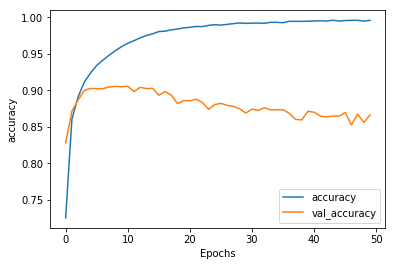

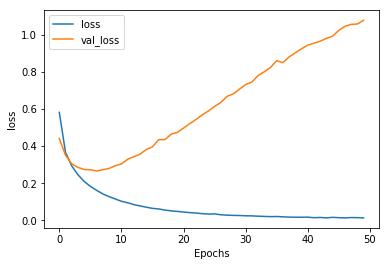

In [10]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(sequence):
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence])

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
print(weights)

(10000, 8)
[[-5.2848876e-02  7.7692363e-03 -2.3439694e-02 ...  3.6248151e-02
   2.6956886e-02  7.5821055e-04]
 [ 1.0602108e-02  3.1077911e-03  5.0769757e-02 ... -5.9190724e-02
  -6.5850563e-02  9.3735419e-02]
 [-6.0229033e-02 -5.9777737e-02 -3.5970002e-02 ... -1.5233399e-02
   6.9933102e-02 -2.5531847e-02]
 ...
 [ 7.3426270e-01  7.3382050e-01  7.7935791e-01 ... -7.3522925e-01
  -7.1088141e-01  8.2318676e-01]
 [-2.6493248e-01 -2.2570162e-01 -2.2754829e-01 ...  2.1254261e-01
   2.2261657e-01 -2.0913826e-01]
 [ 4.9903533e-01  5.3906763e-01  4.8388451e-01 ... -4.5068657e-01
  -5.0997871e-01  5.1243842e-01]]


In [13]:
import io

out_v = io.open('vecs_pseudo-profound.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_pseudo-profound.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [14]:
texts = ["You are basic!", 'Live, laugh, love!']
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[7.62044072e-01]
 [1.12907896e-04]]
